# Projeto final
## Forecasting
### Prof. Paulo Salgado
### Aluno: Silvio Monte

https://classroom.google.com/u/2/c/NTI2NDQzMjg2Mjcx/a/NTI3OTI3ODk1Njg2/details?pli=1

#### Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

import pmdarima as pm
from pmdarima import auto_arima

C:\Users\Silvio\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

In [4]:
import  warnings 
warnings.simplefilter('ignore')

##### Carregando os dados

In [5]:
dados = pd.read_excel('github/vendas_varejo_pe.xlsx')
dados = dados.set_index('data')

##### Variáveis

In [6]:
resultado = pd.DataFrame()
resultado_error = {}

## Análise exploratória

In [7]:
display(dados)

,Venda
data,
2000-01-01,56.0
2000-02-01,54.4
2000-03-01,53.6
2000-04-01,53.5
2000-05-01,57.1
...,...
2015-05-01,110.6
2015-06-01,106.7
2015-07-01,106.8


In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2000-01-01 to 2015-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Venda   189 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [9]:
dados.describe()

,Venda
count,189.000000
mean,80.747090
std,25.945628
min,46.600000
25%,56.100000
50%,77.300000
75%,101.300000
max,163.200000


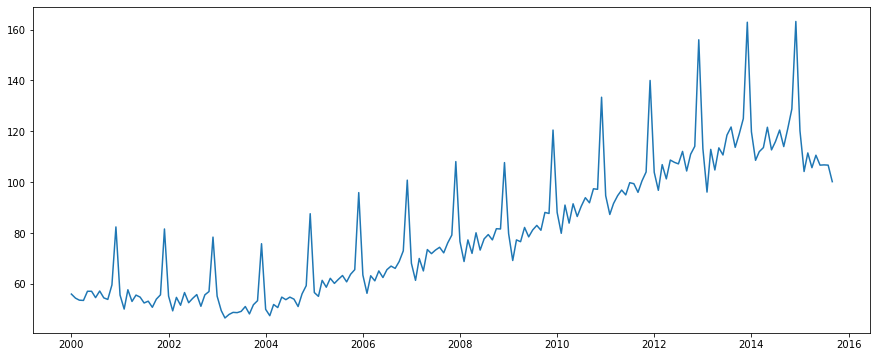

In [10]:
plt.plot(dados)
plt.show()

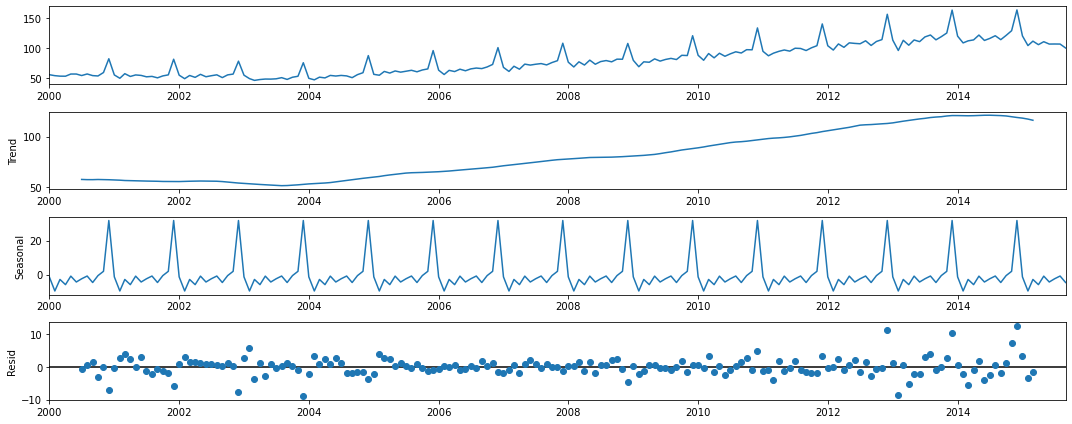

In [11]:
dados_decomp = tsa.seasonal_decompose(dados, period=12)
dados_decomp.plot();

In [12]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

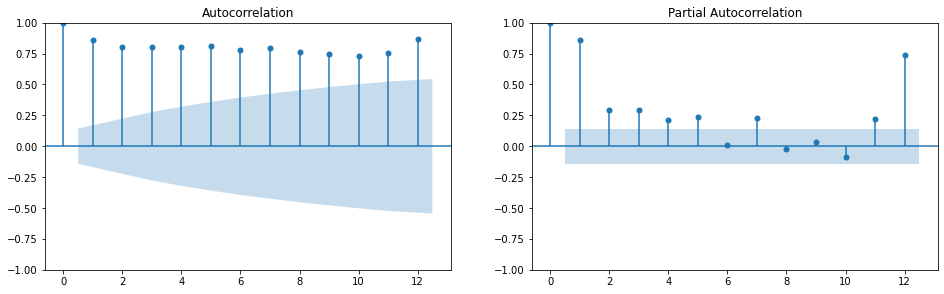

In [13]:
qtd_lag = 12
acf_pacf(dados, qtd_lag)

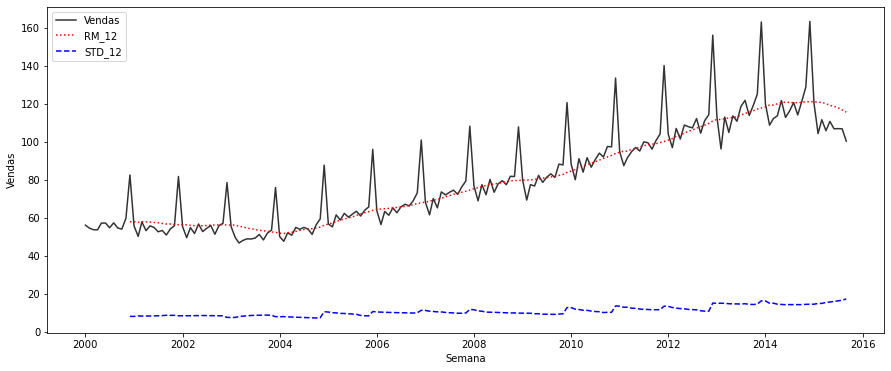

In [14]:
rolmean12 = dados.rolling(window = 12).mean()
rolstd12 = dados.rolling(window = 12).std()

actual = plt.plot(dados['Venda'], color='black', label='Vendas', alpha=0.8)
rm_12 = plt.plot(rolmean12, color='red', label='RM_12', linestyle='dotted')#, 'bo') 
std_12 = plt.plot(rolstd12, color='blue', label='STD_12', linestyle='dashed')#, fmt='2')
plt.legend(loc='best')
plt.xlabel("Semana")
plt.ylabel("Vendas")
plt.show()

In [15]:
def teste_df(serie):
    #H0: série não estacionária 
    dftest = adfuller(serie, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Nº Observações'])
    for key,value in dftest[4].items():
        df_output['Valor Crítico (%s)'%key] = value
    print(df_output)
    if df_output[0] < df_output['Valor Crítico (5%)']: # descarta a H0 se o teste estatistico for menor que o valor crítico 
        print('estacionária')
    else:
        print(df_output[0])
        print('não estacionária')

In [16]:
teste_df(dados.values)

Test Statistic          -1.709506
p-value                  0.426222
#Lags                   14.000000
Nº Observações         174.000000
Valor Crítico (1%)      -3.468502
Valor Crítico (5%)      -2.878298
Valor Crítico (10%)     -2.575704
dtype: float64
-1.7095058233789493
não estacionária


# Separação da base

In [17]:
limite = round(len(dados) * 0.75)
treino = dados[:limite]
teste = dados[limite:]
resultado = teste

In [18]:
if len(dados) == len(treino) + len(teste):
    print("True")

True


 # Arima

In [19]:
model_auto_arima = auto_arima(dados, max_p = 5 , max_q = 5, max_d = 2, 
                         max_P = 2, max_Q = 2, max_D = 2, m = 12, 
                         seasonal = False, trace = True, information_criterion = 'bic', 
                         stepwise = True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1468.500, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1528.913, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1510.401, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1460.905, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1523.732, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1460.911, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1459.728, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1463.383, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=1463.997, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=1468.484, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=1460.470, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.061 seconds


In [20]:
arima_model = ARIMA(treino, order = model_auto_arima.order).fit()
arima_result = arima_model.apply(teste)
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Venda   No. Observations:                   47
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -199.796
Date:                Wed, 21 Sep 2022   AIC                            405.592
Time:                        20:37:05   BIC                            411.078
Sample:                    11-01-2011   HQIC                           407.647
                         - 09-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7009      0.107     -6.521      0.000      -0.911      -0.490
ma.L2         -0.1246      0.106     -1.176      0.240      -0.332       0.083
sigma2        95.1894      7.170     13.276      0.000      81.137     109.242
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                40.38
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             1.72
Prob(H) (two-sided):                  0.56   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Previsão Arima

In [21]:
predict_arima = arima_result.predict().values
predict_arima

array([  0.        , 103.99392687, 125.33609925, 112.25274538,
       108.09079963, 109.3306926 , 106.67795953, 108.29359219,
       107.8924703 , 107.73378625, 109.17517277, 107.17083762,
       108.92790415, 110.02325512, 123.27472738, 114.53246429,
       110.24160587, 113.33163048, 110.44190212, 112.42020574,
       111.52423366, 113.82724098, 115.31539142, 113.85149181,
       115.56346734, 117.75832575, 130.08946055, 121.38834823,
       118.84403553, 118.38944398, 117.80913184, 119.53977439,
       117.02143623, 117.5678546 , 118.57223671, 116.83922323,
       118.653442  , 121.17046856, 132.4795484 , 123.57081251,
       119.30570646, 119.38356879, 116.26250195, 116.27307055,
       114.11467576, 113.11898535, 112.10992203])

In [22]:
resultado['Previsão Arima'] = predict_arima
resultado.head()

,Venda,Previsão Arima
data,,
2011-11-01,104.0,0.000000
2011-12-01,140.0,103.993927
2012-01-01,103.9,125.336099
2012-02-01,96.8,112.252745
2012-03-01,106.9,108.090800


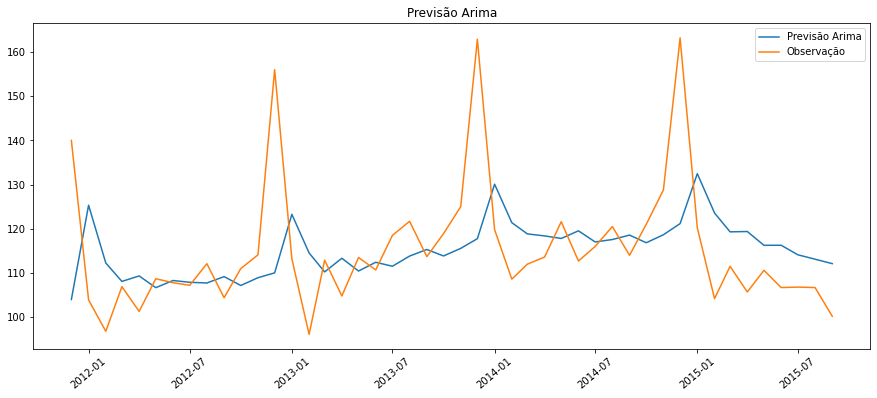

In [23]:
fig, ax = plt.subplots()
ax.plot(resultado['Previsão Arima'].iloc[1:], label='Previsão Arima')
ax.plot(resultado['Venda'].iloc[1:], label='Observação')
#ax.plot(dados['Venda'], label='Observação')
plt.title("Previsão Arima")
plt.xticks(rotation=40)
plt.legend()
plt.legend()

### Erros Arima

#### MSE

In [24]:
resultado_error['Arima MSE'] = mean_squared_error(predict_arima, teste['Venda'])
print(mean_squared_error(predict_arima, teste['Venda']))

453.8225479417194


#### MAPE

In [25]:
resultado_error['Arima MAPE'] = mean_absolute_error(predict_arima, teste['Venda'])
print(mean_absolute_error(predict_arima, teste['Venda']))

12.302839607106325


 # Support Vector Regression (SVR)

### Separação da base

In [26]:
X = treino
y = treino.reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.33)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(teste.shape)

(95, 1)
(95, 1)
(47, 1)
(47, 1)
(47, 2)


In [27]:
teste_predict = teste
teste_predict = teste_predict.reset_index()
teste_predict = teste_predict['data']
teste_predict = pd.DataFrame(teste_predict, columns=['data'])
teste_predict.shape

(47, 1)

## Modelo

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#definindo o tipo de validacao cruzada e o numero de folds
cv_strat = StratifiedKFold(n_splits = 4)

#definindo a estrategia de score a partir da metrica f1
r2 = make_scorer(r2_score)
#definindo hiperparâmetros
distributions = {"n_estimators": list(np.arange(10, 1000, 5)), 
                 "criterion": ["squared_error", "absolute_error"],
                 "max_features": ["auto", "sqrt", "log2"],
                 "max_depth": list(np.arange(1, 100)),
                 "min_samples_split": [2, 5, 10],
                 "min_samples_leaf": [1, 2, 4]}

#instânciando meu classificador
rfr = RandomForestRegressor()

#instanciando e modelando o grid search com os hiperparametros e a validação definidas.
random_cv = RandomizedSearchCV(rfr, distributions, cv = cv_strat, scoring = r2, random_state = 42, n_iter = 10)
random_cv.fit(X_train, y_train)
random_cv.best_params_

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [64]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 'C':[1, 10], 'epsilon':[0.1, 0.2, 0.3]}
model_svr = SVR()

cv_strat = StratifiedKFold(n_splits = 4)

mse = make_scorer(mean_squared_error)
clf = GridSearchCV(model_svr, parameters, scoring = mse, cv = cv_strat)
clf.fit(X_train, y_train)
model_svr = model_svr.predict(X_test)
clf.get_params()

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
#model_svr = SVR(C = 1.0, epsilon = 0.2, kernel = 'linear')
model_svr = SVR(C = 1.0, epsilon = 0.1, kernel = 'rbf')
model_svr.fit(X_train, y_train)
model_svr = model_svr.predict(X_test)

In [45]:
resultado['Previsão SVR'] = model_svr
resultado.head()

,Venda,Previsão Arima,Previsão SVR
data,,,
2011-11-01,104.0,0.000000,64.598941
2011-12-01,140.0,103.993927,73.953904
2012-01-01,103.9,125.336099,68.915354
2012-02-01,96.8,112.252745,73.976434
2012-03-01,106.9,108.090800,71.848054


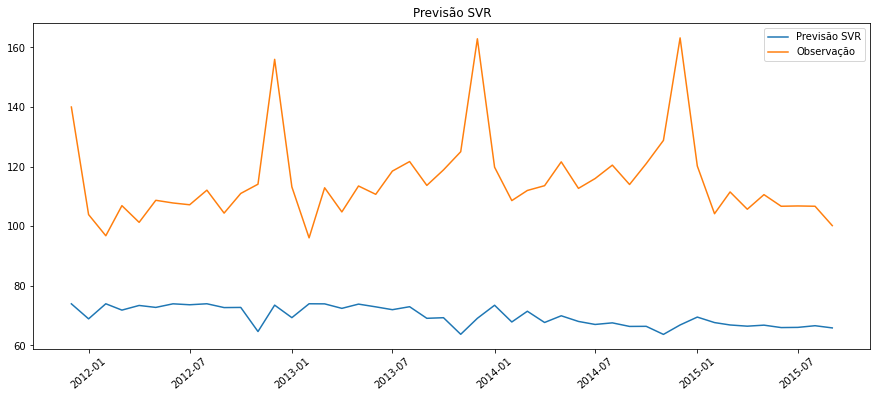

In [46]:
fig, ax = plt.subplots()
ax.plot(resultado['Previsão SVR'].iloc[1:], label='Previsão SVR')
ax.plot(resultado['Venda'].iloc[1:], label='Observação')
#ax.plot(dados['Venda'], label='Observação')
plt.title("Previsão SVR")
plt.xticks(rotation=40)
plt.legend()
plt.legend()

### Erros SVR

#### MSE

In [47]:
resultado_error['SVR MSE'] = mean_squared_error(model_svr, teste['Venda'])
print(mean_squared_error(model_svr, teste['Venda']))

2288.442775185265


#### MAPE

In [40]:
resultado_error['SVR MAPE'] = mean_absolute_error(model_svr, teste['Venda'])
print(mean_absolute_error(model_svr, teste['Venda']))

45.42328144198341


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://github.com/jairpaulino/timeseries_forecasting/blob/main/Case02_AirPassengers.ipynb

https://github.com/Eraylson

https://github.com/amarabuco

https://github.com/jairpaulino/timeseries_forecasting